In [16]:
import pandas as pd
df = pd.read_csv('../3_Machine_Learning/dataset_export_1h.csv')

In [17]:
df['symbol_id'].unique()
df_btc = df[df['symbol_id'] == 1]
df_btc = df_btc.sort_values('open_time')

<Axes: xlabel='open_time'>

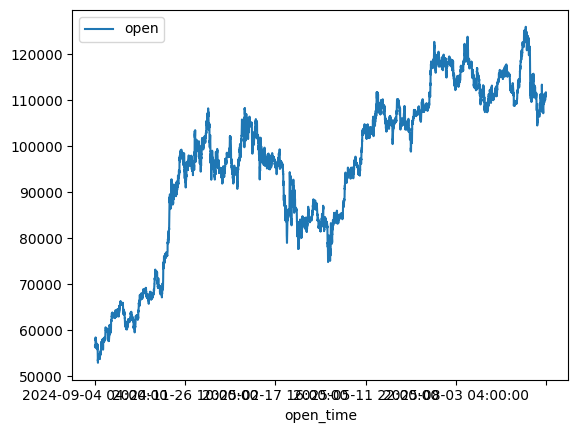

In [28]:
df_btc.plot(x='open_time', y='open')

In [18]:
import ta  # pip install ta

df_btc["rsi"] = ta.momentum.RSIIndicator(df_btc["close"], window=14).rsi()
df_btc["ema_fast"] = ta.trend.EMAIndicator(df_btc["close"], window=10).ema_indicator()
df_btc["ema_slow"] = ta.trend.EMAIndicator(df_btc["close"], window=50).ema_indicator()
df_btc["macd"] = ta.trend.MACD(df_btc["close"]).macd()


In [35]:
future_return = df_btc["close"].shift(-5) / df_btc["close"] - 1
df_btc["signal"] = (future_return > 0.01).astype(int) # achat si plus de 3% de hausse

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features et target
features = ["rsi", "ema_fast", "ema_slow", "macd", "volume"]
X = df_btc[features].dropna()
y = df_btc.loc[X.index, "signal"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entraînement
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1843
           1       0.21      0.03      0.06       148

    accuracy                           0.92      1991
   macro avg       0.57      0.51      0.51      1991
weighted avg       0.87      0.92      0.89      1991



In [37]:
df_btc.loc[X_test.index, "predicted_signal"] = y_pred

# Exemple : 
# Si 1 => achat, si 0 => vente
df_btc["trade_signal"] = df_btc["predicted_signal"].map({1: "BUY", 0: "SELL"})


In [ ]:
## Backtesting

<Axes: title={'center': 'Backtest de la stratégie'}>

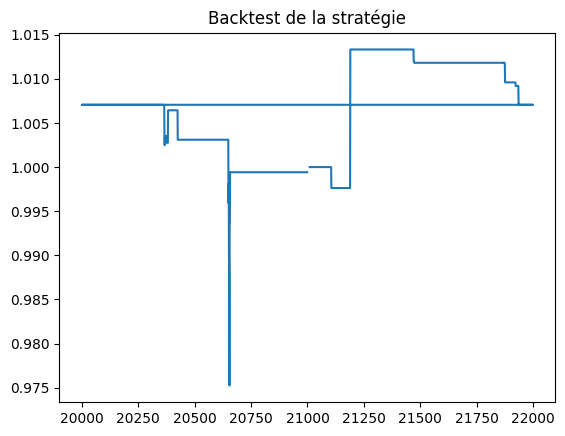

In [38]:
df_btc["strategy_return"] = df_btc["predicted_signal"].shift(1) * df_btc["close"].pct_change()
cumulative_return = (1 + df_btc["strategy_return"]).cumprod()

cumulative_return.plot(title="Backtest de la stratégie")

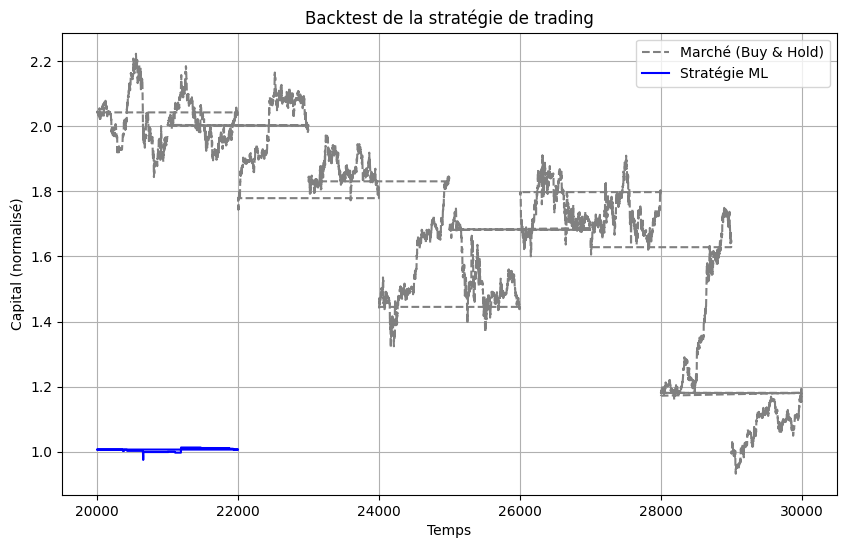

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supposons que ton DataFrame ait les colonnes suivantes :
# df['close'] = prix de clôture
# df['predicted_signal'] = 1 (achat) ou 0 (vente)

# On calcule les rendements quotidiens
df_btc["return"] = df_btc["close"].pct_change()

# La stratégie suit le signal du modèle (1 = long, 0 = neutre/short)
df_btc["strategy_return"] = df_btc["predicted_signal"].shift(1) * df_btc["return"]

# Cumul des rendements
df_btc["cumulative_strategy"] = (1 + df_btc["strategy_return"]).cumprod()
df_btc["cumulative_market"] = (1 + df_btc["return"]).cumprod()

# Visualisation
plt.figure(figsize=(10,6))
#plt.plot(df_btc["close"], label="BTCUSDT", color='pink', linestyle='-.')
plt.plot(df_btc["cumulative_market"], label="Marché (Buy & Hold)", color='gray', linestyle='--')
plt.plot(df_btc["cumulative_strategy"], label="Stratégie ML", color='blue')
plt.legend()
plt.title("Backtest de la stratégie de trading")
plt.xlabel("Temps")
plt.ylabel("Capital (normalisé)")
plt.grid(True)
plt.show()